In [8]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

### Registration of regions of interest (ROIs) to common space

The ROIs of this study are the following:

| Hemisphere | Region | Abbreviation | Origin |   
| :--- |: --- :| --- | --- |   
| L&R | Striatum | STR | ATAG Healthy Young |   
| L&R | Subthalamic nucleus | STN | ATAG Healthy Young |   
| L&R | Globus Pallidus interna | GPi | ATAG Healthy Young |   
| L&R | Globus Pallidus externa | GPe | ATAG Healthy Young |   
| L&R | Pre-supplementary motor area | PreSMA | Boekel et al. (2017); originally from  Johansen-Berg et al. (2004) |   
| R | Inferior frontal gyrus | rIFG | Harvard-Oxford cortical atlas |   
| - | Anterior Cingulate Cortedx | ACC | Harvard-Oxford cortical atlas |   
| L&R | Primary motor cortex | M1 | Harvard-Oxford cortical atlas |   

----
###### References:
Boekel, Forstmann, Keuken (2017). A test-retest reliability analysis of diffusion measures of white matter tracts relevant for cognitive control. Psychophysiology, 54, 24-33.

Johansen-Berg, H., Behrens, T., Robson, M. D., Drobnjak, I., Rushworth, M., Brady, J. M., . . . Matthews, P. M. (2004). Changes in connectivity profiles define functionally distinct regions in human medial frontal cortex. Pro- ceedings of the National Academy of Sciences of the United States of America, 101(36), 13335–13340. doi: 10.1073/pnas.0403743101

Keuken, M. C., Bazin, P.-L., Crown, L., Hootsmans, J., Laufer, A., M€uller- Axt, C., . . . Forstmann, B. U. (2014). Quantifying inter-individual ana- tomical variability in the subcortex using 7T structural MRI. Neuro- Image, 94(1), 40–46. doi: 10.1016/j.neuroimage.2014.03.032

In [9]:
import nighres
import os
import nibabel as nib
from nighres.registration import embedded_antsreg, apply_coordinate_mappings
from nilearn import plotting
%matplotlib inline

## All anatomicl images to register
mni05_brain = '/data/templates/MNI05_standard/standard/MNI152_T1_1mm_brain.nii.gz'  # 1 mm
mni05_brain_p4mm = './masks/orig_Boekel_et_al/MNI152_T1_04mm_brain.nii.gz'  # 0.4 mm
mni09a_brain = '/data/templates/mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm.nii.gz' # 09a 1mm

registration_dir = './masks/registration'
if not os.path.exists(registration_dir):
    os.makedirs(registration_dir)

In [10]:
# utility function to checkout registration results
def make_report(fixed_image, moving_image, output_dir=os.getcwd(), fn='report.svg',
               compress_report=False):
    from nipype.interfaces.base import File
    _fixed_image = fixed_image
    _moving_image = moving_image
    _fixed_image_mask = None
    _fixed_image_label = "fixed"
    _moving_image_label = "moving"
    _contour = None
    #    _out_report = File('report.svg', usedefault=True, desc='filename for the visual report')#'report.svg'
    _out_report = os.path.abspath(os.path.join(output_dir, fn))

    from niworkflows.viz.utils import plot_registration, compose_view, cuts_from_bbox
    from nilearn.masking import apply_mask, unmask
    from nilearn.image import threshold_img, load_img

    fixed_image_nii = load_img(_fixed_image)  # template
    moving_image_nii = load_img(_moving_image)  # source
    contour_nii = load_img(_contour) if _contour is not None else None

    if _fixed_image_mask:
        fixed_image_nii = unmask(apply_mask(fixed_image_nii,
                                            _fixed_image_mask),
                                 _fixed_image_mask)
        # since the moving image is already in the fixed image space we
        # should apply the same mask
        moving_image_nii = unmask(apply_mask(moving_image_nii,
                                             _fixed_image_mask),
                                  _fixed_image_mask)
        mask_nii = load_img(_fixed_image_mask)
    else:
        mask_nii = threshold_img(fixed_image_nii, 1e-3)

    n_cuts = 7
    if not _fixed_image_mask and contour_nii:
        cuts = cuts_from_bbox(contour_nii, cuts=n_cuts)
    else:
        cuts = cuts_from_bbox(mask_nii, cuts=n_cuts)

    # Call composer
    compose_view(
        plot_registration(fixed_image_nii, 'fixed-image',
                          estimate_brightness=True,
                          cuts=cuts,
                          label=_fixed_image_label,
                          contour=contour_nii,
                          compress=compress_report),
        plot_registration(moving_image_nii, 'moving-image',
                          estimate_brightness=True,
                          cuts=cuts,
                          label=_moving_image_label,
                          contour=contour_nii,
                          compress=compress_report),
        out_file=_out_report
    )
    return _out_report

#### Make all masks from ATAG probabilistic, set all on same scale

In [13]:
def make_probabilistic(fn, max_value=30):
    hdr = nib.load(fn)
    dat = hdr.get_data() / max_value * 100
    img = nib.Nifti1Image(dat, hdr.affine)
    return img

# abs_value_masks = {
#     'STR_L': './masks/orig_Boekel_et_al/01_STR_L.nii.gz',
#     'STR_R': './masks/orig_Boekel_et_al/02_STR_R.nii.gz',
#     'STN_L': './masks/orig_Boekel_et_al/05_STN_L.nii.gz',
#     'STN_R': './masks/orig_Boekel_et_al/06_STN_R.nii.gz',
# #     'GPi_L': './masks/MNI05/GPi_L_prob_mni_non_linear_young.nii.gz',
# #     'GPi_R': './masks/MNI05/GPi_R_prob_mni_non_linear_young.nii.gz',
# #     'GPe_L': './masks/MNI05/GPe_L_prob_mni_non_linear_young.nii.gz',
# #     'GPe_R': './masks/MNI05/GPe_R_prob_mni_non_linear_young.nii.gz',
# }

# ##### ADD GPe GPi!!
# for mask, fn in abs_value_masks.items():
#     nib.save(make_probabilistic(fn), fn.replace('.nii.gz', '_prob_map.nii.gz').replace('orig_Boekel_et_al', 'modified_from_Boekel_et_al').replace('MNI05', 'modified_from_ATAG'))

# the PreSMA-masks are not probabilistic but 1/0. For compatibility with the other masks, let's convert this to 100/0.

preSMA_masks = {
    '1': './masks/orig_Boekel_et_al/03_PreSMA_L.nii.gz',
    '2': './masks/orig_Boekel_et_al/04_PreSMA_R.nii.gz',
}

for mask, fn in preSMA_masks.items():
    nib.save(make_probabilistic(fn, max_value=1), fn.replace('.nii.gz', '_rescaled.nii.gz').replace('orig_Boekel_et_al', 'modified_from_Boekel_et_al'))

### Calculate warps
1. MNI05 -> MNI09a
2. MNI05 p4mm -> MNI05 1mm

In [14]:
### Register MNI05 1mm to MNI09a (syn)
syn_res = embedded_antsreg(source_image=mni05_brain,
                           target_image=mni09a_brain, 
                           output_dir=registration_dir, save_data=True, overwrite=False)


Embedded ANTs Registration


/usr/local/miniconda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)



Outputs will be saved to ./masks/registration/
skip computation (use existing results)


/usr/local/miniconda/lib/python3.6/site-packages/niworkflows/__init__.py:24: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/miniconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/miniconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/miniconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/miniconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.i

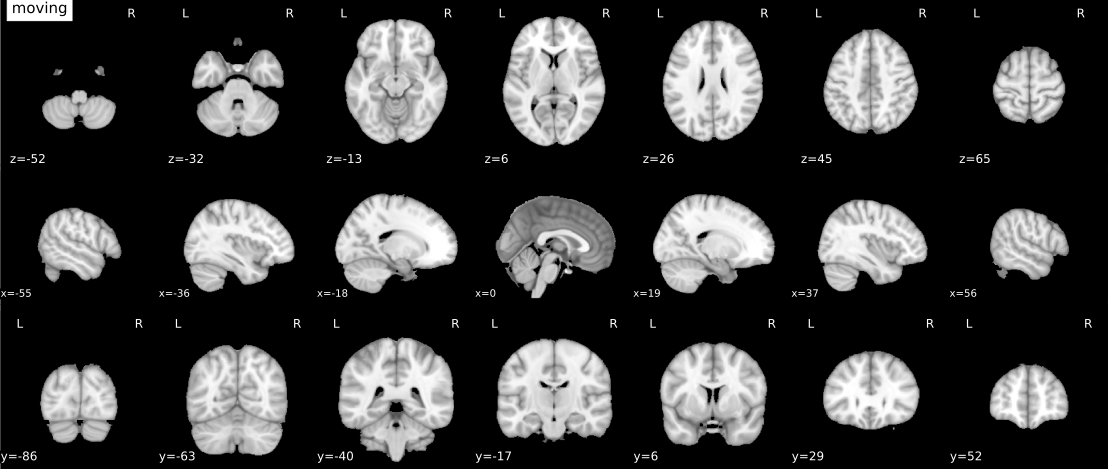

In [15]:
### Checkout registration quality
mni05_1mm_2_mni09a_svg = make_report(fixed_image=mni09a_brain, moving_image=syn_res['transformed_source'],
                                     output_dir=registration_dir, fn='mni05_1mm_2_mni09a.svg')
from IPython.display import SVG, display
display(SVG(mni05_1mm_2_mni09a_svg))

Not so much wrong with this

In [16]:
### Register MNI05 0.4mm to MNI05 1.0mm (rigid)
### NOTE TO SELF: next time, simply set all iterations to 0.
syn_res2 = embedded_antsreg(source_image=mni05_brain_p4mm,
                            target_image=mni05_brain,
                            run_syn=False, run_affine=False,
                            output_dir=registration_dir, save_data=True, overwrite=False)


Embedded ANTs Registration

Outputs will be saved to ./masks/registration/
skip computation (use existing results)


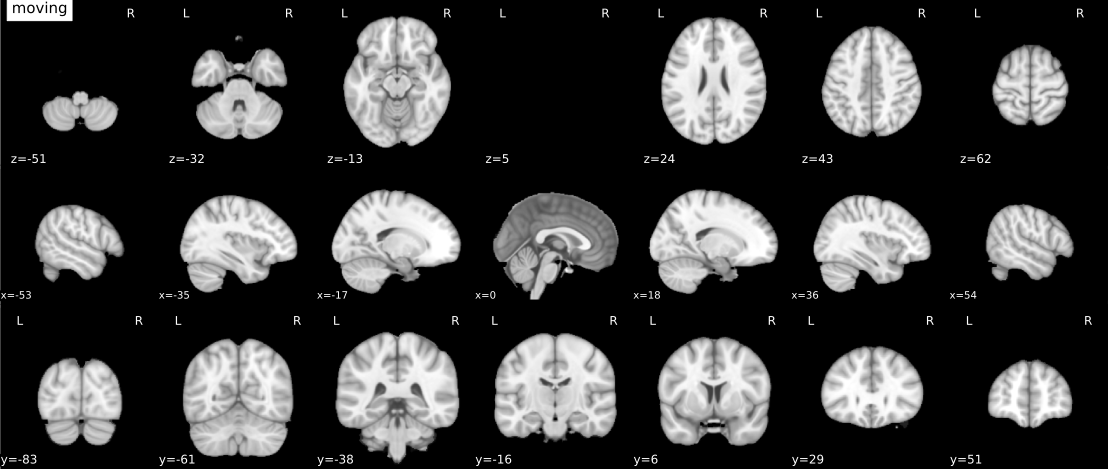

In [17]:
### Checkout registration quality
mni05_p4mm_2_mni05_1mm_svg = make_report(fixed_image=mni05_brain, moving_image=syn_res2['transformed_source'],
                                     output_dir=registration_dir, fn='mni05_p4mm_2_mni05_1mm.svg')
from IPython.display import SVG, display
display(SVG(mni05_p4mm_2_mni05_1mm_svg))
### since this is basically a resample to a lower resolution, this is spot on

In [18]:
### Combine warps: MNI05 0.4mm -> MNI05 1mm -> 09a 1mm
mapping1 = registration_dir + '/MNI152_T1_04mm_brain_ants-map.nii.gz'
mapping2 = registration_dir + '/MNI152_T1_1mm_brain_ants-map.nii.gz'

mni05_p4_to_mni09a = apply_coordinate_mappings(image=mni05_brain_p4mm, 
                                               mapping1=mapping1,
                                               mapping2=mapping2, 
                                               save_data=True, overwrite=False, output_dir=registration_dir)


Apply coordinate mappings

Outputs will be saved to ./masks/registration/
skip computation (use existing results)


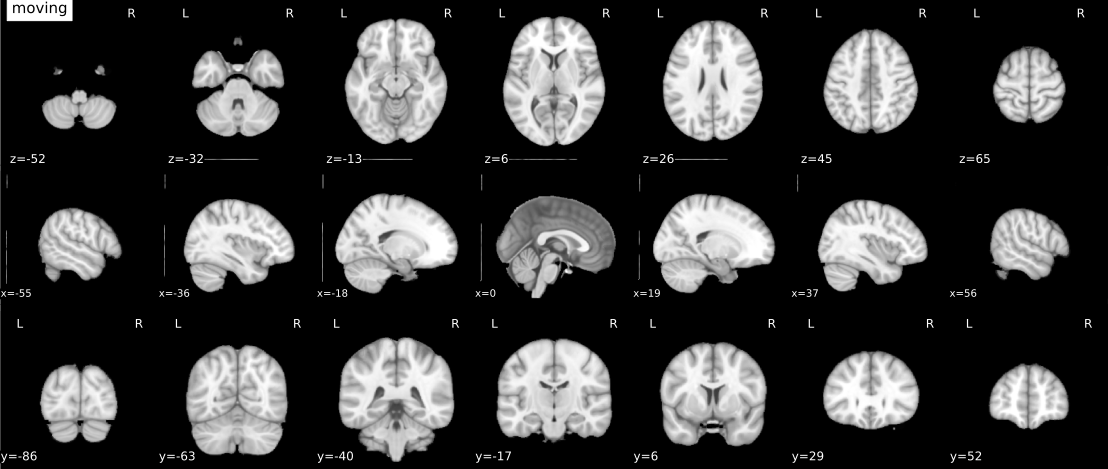

In [19]:
### Checkout registration quality
mni05_p4mm_2_mni09a_svg = make_report(fixed_image=mni09a_brain, moving_image=mni05_p4_to_mni09a['result'],
                                      output_dir=registration_dir, fn='mni05_p4mm_2_mni09a.svg')
from IPython.display import SVG, display
display(SVG(mni05_p4mm_2_mni09a_svg))

### Registration is fine

### 2. Get Harvard-Oxford ROIs

In [239]:
### Get Harvard-Oxford ROIs
from nilearn.datasets import fetch_atlas_harvard_oxford
ho_atlas = fetch_atlas_harvard_oxford(atlas_name='cort-prob-1mm')
ho_maps = nib.load(ho_atlas['maps'])

def get_slice(labels, name):
    slice_idx = [x for x, i in enumerate(labels) if i == name]
    return slice_idx[0] - 1

def get_atlas_img(atlas, slice_idx=0):
    dat = atlas.get_data()[:,:,:,slice_idx]
    img = nib.Nifti1Image(dat, atlas.affine)
    return img

def get_hemisphere(hdr, side='R'):
    if isinstance(hdr, str):
        hdr = nib.load(hdr)
    dat = hdr.get_data()
    
    if side == 'R':
        if hdr.affine[0,0] < 0: # right-left
            dat[int(dat.shape[0]/2):,:,:] = 0
        else:
            dat[:int(dat.shape[0]/2),:,:] = 0
    else:
        if hdr.affine[0,0] < 0: # right-left
            dat[:int(dat.shape[0]/2),:,:] = 0
        else:
            dat[int(dat.shape[0]/2):,:,:] = 0
    
    return nib.Nifti1Image(dat, hdr.affine)

#M1_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Precentral Gyrus'))
#plotting.plot_roi(get_hemisphere(M1_prob_map, side='L'), bg_img=mni09a_brain)

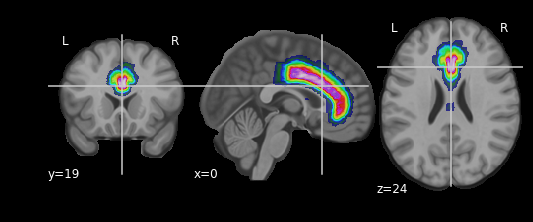

In [244]:
## Anterior cingulate
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
ACC_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Cingulate Gyrus, anterior division'))
plotting.plot_roi(ACC_prob_map, bg_img=mni09a_brain)

#nib.save(ACC_prob_map, filename='./masks/original_harvard_oxford_mni05/ACC_prob_map.nii.gz')

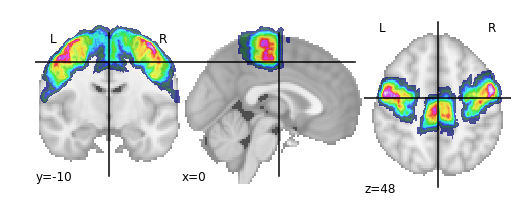

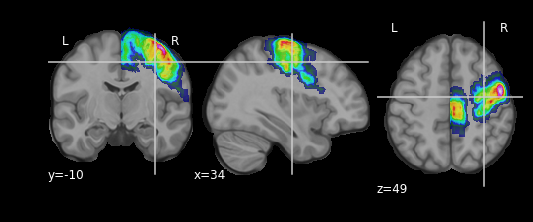

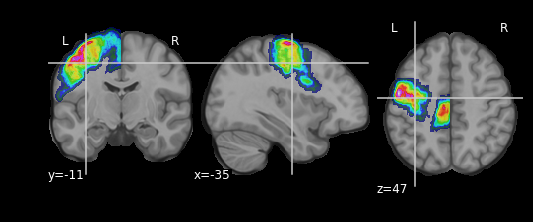

In [245]:
## M1 = Precentral Gyrus
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
M1_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Precentral Gyrus'))
plotting.plot_roi(M1_prob_map)
nib.save(M1_prob_map, filename='./masks/original_harvard_oxford_mni05/M1_prob_map.nii.gz')

# take right hemisphere only
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
M1_R_prob_map = get_hemisphere(M1_prob_map, side='R')
plotting.plot_roi(M1_R_prob_map, bg_img=mni09a_brain)
nib.save(M1_R_prob_map, filename='./masks/original_harvard_oxford_mni05/M1_R_prob_map.nii.gz')

# left hemisphere
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
M1_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Precentral Gyrus'))
M1_L_prob_map = get_hemisphere(M1_prob_map, side='L')
plotting.plot_roi(M1_L_prob_map, bg_img=mni09a_brain)
nib.save(M1_L_prob_map, filename='./masks/original_harvard_oxford_mni05/M1_L_prob_map.nii.gz')

In [241]:
def sum_masks(mask1, mask2):
    dat = mask1.get_data() + mask2.get_data()
    img = nib.Nifti1Image(dat, mask1.affine)
    return img

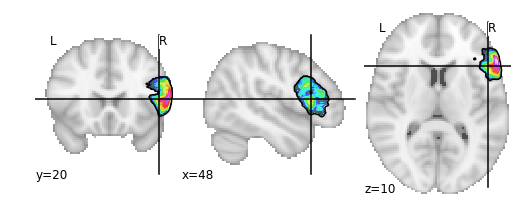

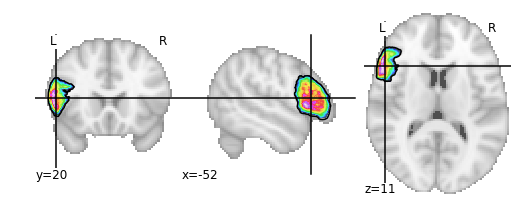

In [248]:
## rIFG: combine pars triangularis & pars opercularis in a single mask, then get right hemisphere
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
IFG_pars_tr_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars triangularis'))
IFG_pars_op_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars opercularis'))
# plotting.plot_roi(get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars triangularis')), bg_img=mni09a_brain)
# plotting.plot_roi(get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars opercularis')), bg_img=mni09a_brain)

# make summed mask, both hemispheres
IFG_prob_map = sum_masks(IFG_pars_tr_prob_map, IFG_pars_op_prob_map)
nib.save(IFG_prob_map, filename='./masks/modified_from_harvard_oxford/IFG_prob_map.nii.gz')

# get & save right IFG only
rIFG_prob_map = get_hemisphere(IFG_prob_map, side='R')
disp = plotting.plot_roi(rIFG_prob_map, threshold=20, cut_coords=[48, 20, 10])
nib.save(rIFG_prob_map, filename='./masks/modified_from_harvard_oxford/IFG_R_prob_map.nii.gz')
add_contours(disp, './masks/modified_from_harvard_oxford/IFG_R_prob_map.nii.gz', thr=20, colors=['black'])



## rIFG: combine pars triangularis & pars opercularis in a single mask, then get right hemisphere
ho_maps = nib.load(ho_atlas['maps']) # reload to prevent in-place changes of already bound objects
IFG_pars_tr_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars triangularis'))
IFG_pars_op_prob_map = get_atlas_img(ho_maps, get_slice(ho_atlas.labels, 'Inferior Frontal Gyrus, pars opercularis'))
# make summed mask, both hemispheres
IFG_prob_map = sum_masks(IFG_pars_tr_prob_map, IFG_pars_op_prob_map)

# get & save left IFG only
lIFG_prob_map = get_hemisphere(IFG_prob_map, side='L')
disp = plotting.plot_roi(lIFG_prob_map, threshold=20)
nib.save(lIFG_prob_map, filename='./masks/modified_from_harvard_oxford/IFG_L_prob_map.nii.gz')
add_contours(disp, './masks/modified_from_harvard_oxford/IFG_L_prob_map.nii.gz', thr=20, colors=['black'])

### Apply warps to ROIs
##### 1. 05 -> 09a

In [20]:
roi_dict_mni05 = {
    'STR_L': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_MP2RAGE_STR_interrater_prop_L_normalized_1mm.nii.gz',
    'STR_R': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_MP2RAGE_STR_interrater_prop_R_normalized_1mm.nii.gz',
    'STN_L': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_FLASH_STh_interrater_prop_L_normalized_1mm.nii.gz',
    'STN_R': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_FLASH_STh_interrater_prop_R_normalized_1mm.nii.gz',
    'PreSMA_L': './masks/modified_from_Boekel_et_al/03_PreSMA_L_rescaled.nii.gz',
    'PreSMA_R': './masks/modified_from_Boekel_et_al/04_PreSMA_R_rescaled.nii.gz',
    'GPi_L': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPi_interrater_prop_L_normalized_1mm.nii.gz',
    'GPi_R': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPi_interrater_prop_R_normalized_1mm.nii.gz',
    'GPe_L': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPe_interrater_prop_L_normalized_1mm.nii.gz',
    'GPe_R': './masks/ATAG_MNI04_1mm_space/Non-Linear/normalized/Nonlinear_QSM_GPe_interrater_prop_R_normalized_1mm.nii.gz',
    'rIFG': './masks/modified_from_harvard_oxford/IFG_R_prob_map.nii.gz',
    'ACC': './masks/original_harvard_oxford_mni05/ACC_prob_map.nii.gz',
    'M1': './masks/original_harvard_oxford_mni05/M1_prob_map.nii.gz',
    'M1_R': './masks/original_harvard_oxford_mni05/M1_R_prob_map.nii.gz',
    'M1_L': './masks/original_harvard_oxford_mni05/M1_L_prob_map.nii.gz'
}

mapping1 = registration_dir + '/MNI152_T1_04mm_brain_ants-map.nii.gz'
mapping2 = registration_dir + '/MNI152_T1_1mm_brain_ants-map.nii.gz'

redo = False
final_masks_mni09a_1mm = './masks/final_masks_mni09a_1mm'
if not os.path.exists(final_masks_mni09a_1mm):
    os.makedirs(final_masks_mni09a_1mm)

for mask, fn in roi_dict_mni05.items():
    if 'PreSMA' in mask:
        # two mappings
        apply_coordinate_mappings(fn, mapping1=mapping1, mapping2=mapping2, save_data=True, output_dir=final_masks_mni09a_1mm, file_name=mask,
                                 overwrite=redo)
    else:
        # single mapping
        apply_coordinate_mappings(fn, mapping1=mapping2, save_data=True, output_dir=final_masks_mni09a_1mm, file_name=mask,
                                 overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1mm/
skip computation (use existing results)


/usr/local/miniconda/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/miniconda/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/miniconda/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/miniconda/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/miniconda/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/miniconda/lib/python3.6/site-packages/matplo

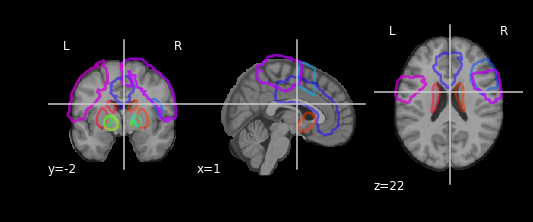

In [21]:
### Rois in MNI09-space
roi_dict_mni09a = {
    'STR_L': final_masks_mni09a_1mm + '/STR_L_def-img.nii.gz',
    'STR_R': final_masks_mni09a_1mm + '/STR_R_def-img.nii.gz',
    'STN_L': final_masks_mni09a_1mm + '/STN_L_def-img.nii.gz',
    'STN_R': final_masks_mni09a_1mm + '/STN_R_def-img.nii.gz',
    'GPi_L': final_masks_mni09a_1mm + '/GPi_L_def-img.nii.gz',
    'GPi_R': final_masks_mni09a_1mm + '/GPi_R_def-img.nii.gz',
    'GPe_L': final_masks_mni09a_1mm + '/GPe_L_def-img.nii.gz',
    'GPe_R': final_masks_mni09a_1mm + '/GPe_R_def-img.nii.gz',
    'PreSMA_L': final_masks_mni09a_1mm + '/PreSMA_L_def-img.nii.gz',
    'PreSMA_R': final_masks_mni09a_1mm + '/PreSMA_R_def-img.nii.gz',
    'rIFG': final_masks_mni09a_1mm + '/rIFG_def-img.nii.gz',
    'ACC': final_masks_mni09a_1mm + '/ACC_def-img.nii.gz',
    'M1': final_masks_mni09a_1mm + '/M1_def-img.nii.gz',
    'M1_R': final_masks_mni09a_1mm + '/M1_R_def-img.nii.gz',
    'M1_L': final_masks_mni09a_1mm + '/M1_L_def-img.nii.gz',
}

# make nice plot
from nilearn import image
combined = image.concat_imgs(roi_dict_mni09a.values())
plotting.plot_prob_atlas(combined, bg_img=mni09a_brain, view_type='contours', threshold=0.3)

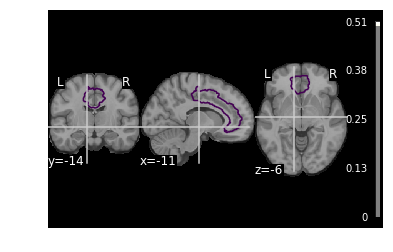

In [22]:
def add_contours(disp, roi, thr=0.3, **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    map_img = nib.load(roi)
    data = map_img.get_data()
    thr = check_threshold(thr, data,
                      percentile_func=fast_abs_percentile,
                      name='threshold')
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    disp.add_contours(roi, levels=[thr], **kwargs)
    
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1)
disp = plotting.plot_stat_map(roi_dict_mni09a['STN_L'], threshold=0.5, bg_img=mni09a_brain, axes=ax)
add_contours(disp, roi_dict_mni09a['ACC'])


#### 2. MNI05 -> MNI09a 1p6mm (BOLD-resolution)

Below, I created the mean BOLD image (i.e., per subject mean of ses-se_run-1; then mean over subjects) as a target for registration.
But much simpler would be to select *any* BOLD-image (that was registered to MNI09a-space) and run embedded_syn without any iterations...

In [22]:
# all subjects first run image
ses_se_run1_imgs = glob('./data/deriv/fmriprep/sub-*/ses-se/func/*run-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz')
ses_se_run1_mean_img = []
for img in ses_se_run1_imgs:
    ses_se_run1_mean_img.append(mean_img(img))  # mean over time series
    
ses_se_run1_imgs = image.concat_imgs(ses_se_run1_mean_img)  # concat mean images
final_mean = mean_img(ses_se_run1_imgs)  # mean again
fn = os.path.join(registration_dir, 'mean-func_space-mni152.nii.gz')
nib.save(final_mean, filename=fn)

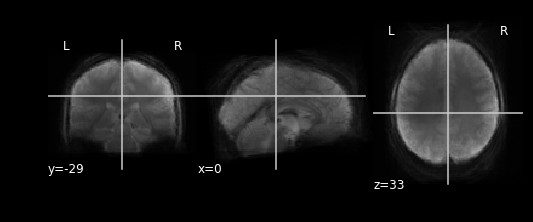

In [23]:
plotting.plot_anat(fn)

In [193]:
target_fn = os.path.join(registration_dir, 'mean-func_space-mni152.nii.gz')  # this was an old mean functional image, but any func image should suffice
# no iterations: simply downsample
syn_res = embedded_antsreg(source_image=mni09a_brain,
                           target_image=target_fn,
                           coarse_iterations=0,
                           medium_iterations=0,
                           fine_iterations=0,
                           run_rigid=True,
                           run_syn=False,
                           run_affine=False,
                           save_data=True,
                           output_dir=registration_dir,
                           file_name='MNI09a_2_1p6mm',
                           overwrite=False)

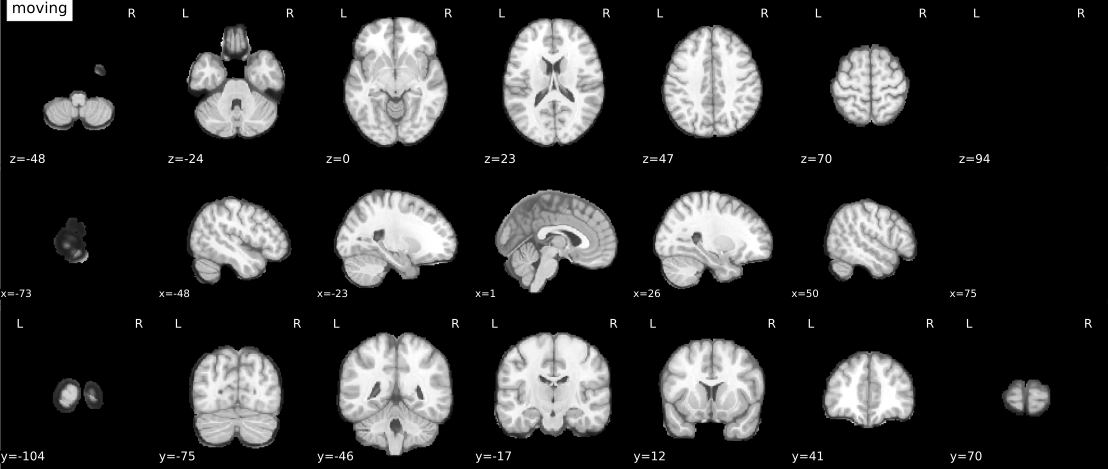

In [254]:
mni09a_2_1p6mm_svg = make_report(fixed_image=target_fn, 
                                 moving_image='./masks/registration/MNI09a_2_1p6mm_ants-def.nii.gz', #syn_res['transformed_source'],
                                 output_dir=registration_dir, fn='mni09a_2_1p6mm.svg')
from IPython.display import SVG, display
display(SVG(mni09a_2_1p6mm_svg))

In [25]:
### Apply transforms to each mask; save again
mapping_mni05_0p4_2_1mm = './masks/registration/MNI152_T1_04mm_brain_ants-map.nii.gz'
mapping_mni05_1mm_2_mni09a = './masks/registration/MNI152_T1_1mm_brain_ants-map.nii.gz'
mapping_mni09a_2_1p6mm = './masks/registration/MNI09a_2_1p6mm_ants-map.nii.gz'

final_masks_mni09a_1p6mm = './masks/final_masks_mni09a_1p6mm'
if not os.path.exists(final_masks_mni09a_1p6mm):
    os.makedirs(final_masks_mni09a_1p6mm)

redo=False
for mask, fn in roi_dict_mni05.items():
    if 'PreSMA' in mask:
        apply_coordinate_mappings(fn, 
                          mapping1=mapping_mni05_0p4_2_1mm,      # 05 p4 -> 05 1mm
                          mapping2=mapping_mni05_1mm_2_mni09a,   # 05 -> 09a
                          mapping3=mapping_mni09a_2_1p6mm,       # 09a 1mm -> 09a 1.6mm
                          save_data=True, output_dir=final_masks_mni09a_1p6mm, file_name=mask,
                          overwrite=redo)
    else:
        apply_coordinate_mappings(fn, 
                                  mapping1=mapping_mni05_1mm_2_mni09a,   # 05 -> 09a
                                  mapping2=mapping_mni09a_2_1p6mm,       # 09a -> 09a 1.6mm
                                  save_data=True, output_dir=final_masks_mni09a_1p6mm, file_name=mask,
                                  overwrite=redo)


Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to ./masks/final_masks_mni09a_1p6mm/
skip computation (use ex

Max value: 1.000
Max value: 1.000
Max value: 0.508


/usr/local/miniconda/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/usr/local/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/usr/local/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/usr/local/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/usr/local/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/usr/local/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, n

Max value: 0.451
Max value: 0.919
Max value: 0.945
Max value: 0.986
Max value: 0.984
Max value: 100.000
Max value: 100.000
Max value: 90.000
Max value: 100.000
Max value: 93.000
Max value: 90.000
Max value: 93.000


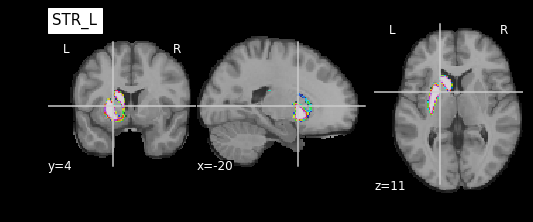

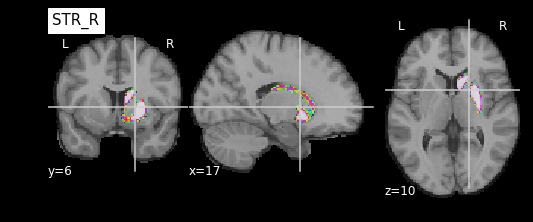

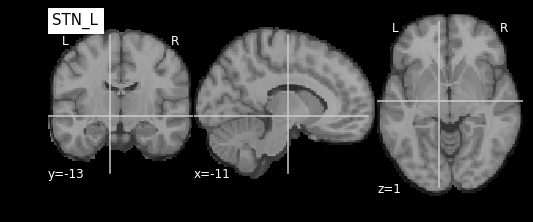

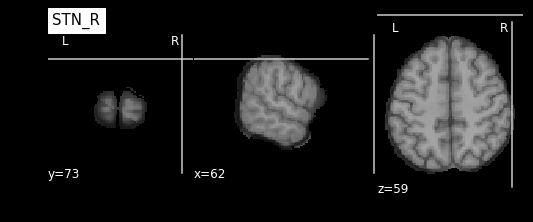

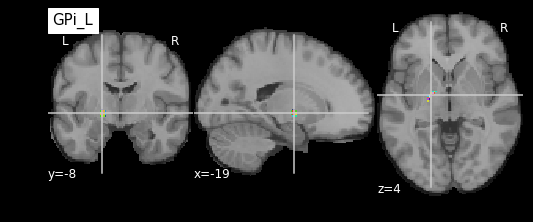

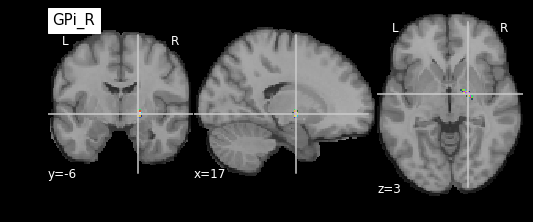

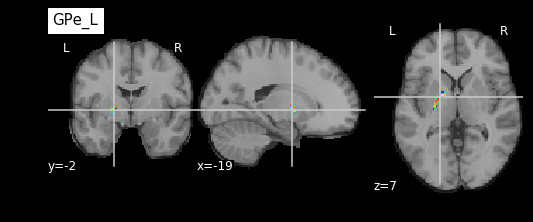

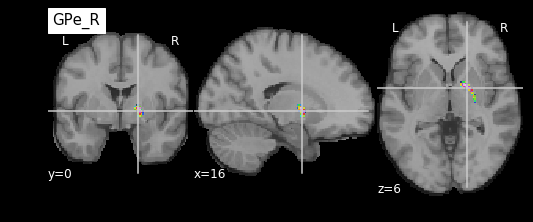

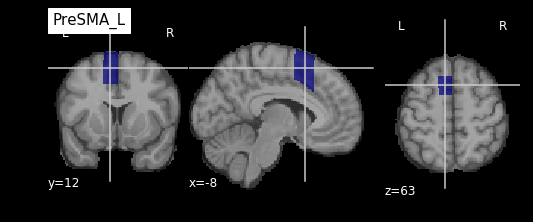

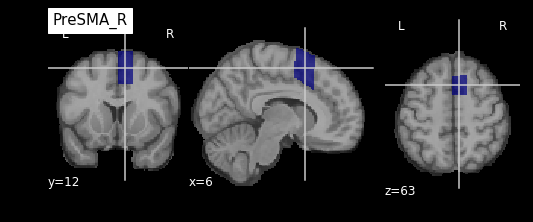

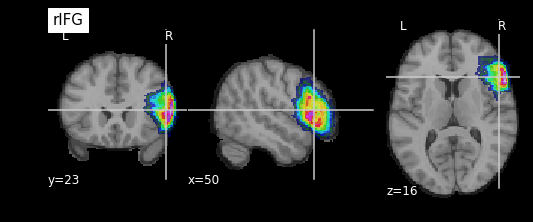

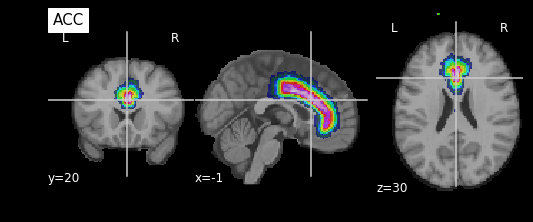

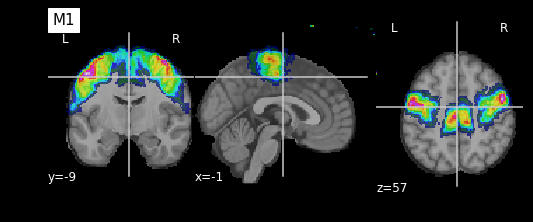

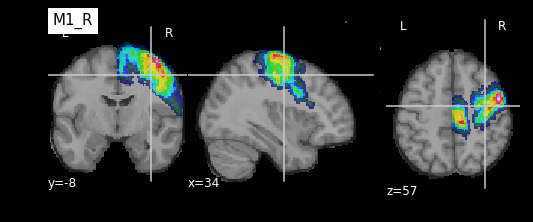

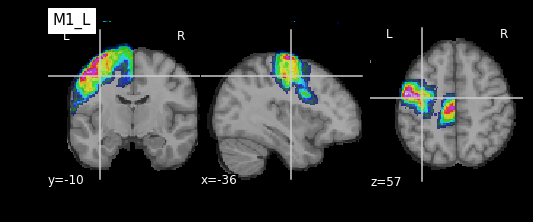

In [26]:
### Rois in MNI09-space
roi_dict_mni09a_1p6mm = {
    'STR_L': final_masks_mni09a_1p6mm + '/STR_L_def-img.nii.gz',
    'STR_R': final_masks_mni09a_1p6mm + '/STR_R_def-img.nii.gz',
    'STN_L': final_masks_mni09a_1p6mm + '/STN_L_def-img.nii.gz',
    'STN_R': final_masks_mni09a_1p6mm + '/STN_R_def-img.nii.gz',
    'GPi_L': final_masks_mni09a_1p6mm + '/GPi_L_def-img.nii.gz',
    'GPi_R': final_masks_mni09a_1p6mm + '/GPi_R_def-img.nii.gz',
    'GPe_L': final_masks_mni09a_1p6mm + '/GPe_L_def-img.nii.gz',
    'GPe_R': final_masks_mni09a_1p6mm + '/GPe_R_def-img.nii.gz',
    'PreSMA_L': final_masks_mni09a_1p6mm + '/PreSMA_L_def-img.nii.gz',
    'PreSMA_R': final_masks_mni09a_1p6mm + '/PreSMA_R_def-img.nii.gz',
    'rIFG': final_masks_mni09a_1p6mm + '/rIFG_def-img.nii.gz',
    'ACC': final_masks_mni09a_1p6mm + '/ACC_def-img.nii.gz',
    'M1': final_masks_mni09a_1p6mm + '/M1_def-img.nii.gz',
    'M1_R': final_masks_mni09a_1p6mm + '/M1_R_def-img.nii.gz',
    'M1_L': final_masks_mni09a_1p6mm + '/M1_L_def-img.nii.gz'
}

for mask, fn in roi_dict_mni09a_1p6mm.items():
    _ = plotting.plot_roi(fn, bg_img = registration_dir + '/MNI09a_2_1p6mm_ants-def.nii.gz', title=mask)
    print('Max value: %.3f' %nib.load(fn).get_data().max())

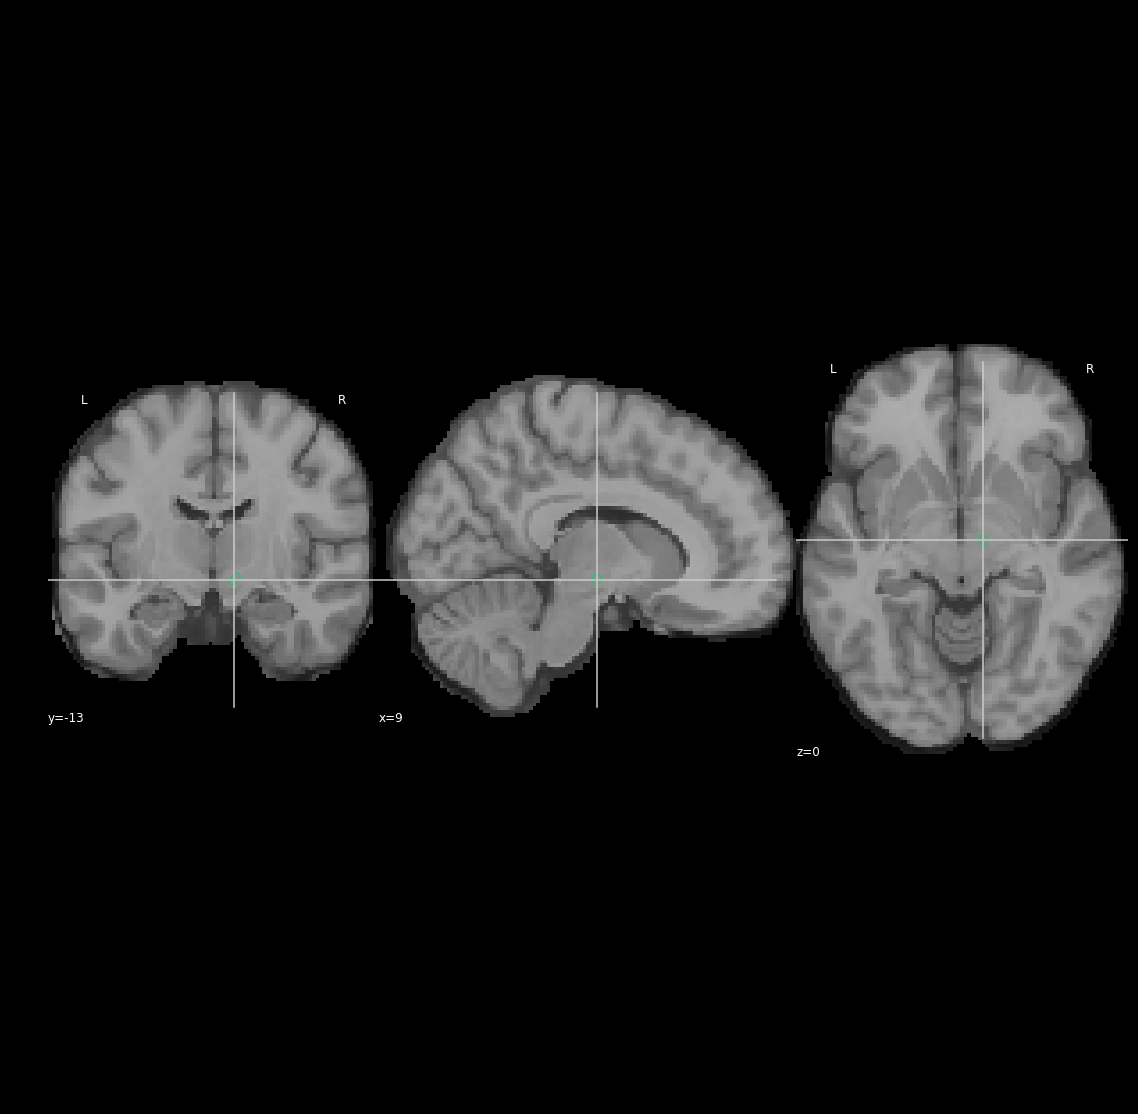

In [105]:
disp = plotting.plot_roi(roi_dict_mni09a_1p6mm['STN_R'], bg_img=registration_dir + '/MNI09a_2_1p6mm_ants-def.nii.gz',
                         vmin=0.01, vmax=0.1, cut_coords=[9, -13, 0])#, vmin=0, vmax=0.3)
add_contours(disp, roi_dict_mni09a_1p6mm['STN_R'])
plt.gcf().set_size_inches(15,15)

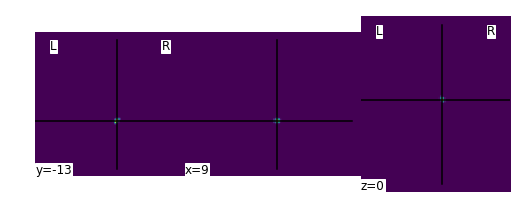

In [96]:
plotting.plot_img(roi_dict_mni09a_1p6mm['STN_R'])

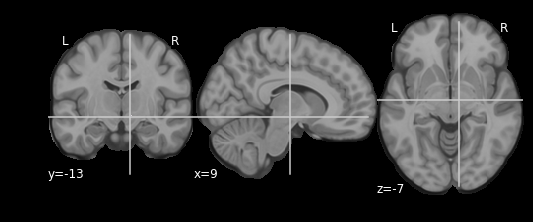

In [68]:
plotting.plot_roi(roi_dict_mni09a['STN_R'], bg_img=mni09a_brain)